In [127]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import Birch
from sklearn.manifold import TSNE

In [128]:
df = pd.read_csv('data/mars_2015.csv', sep=',',dtype={"latitude":float,"longitude":float,"wind_direction_true":float,"wind_speed":float,"present_weather":float,"sea_level_pressure":float,"air_temperature":float,"wetbulb_temperature":float,"sea_surface_temp":float},low_memory=False)

In [129]:
# delete index of all dataset
df = df.drop(df.columns[0],axis=1)
df_origin_data = df
df.head(3)

,latitude,longitude,wind_direction_true,wind_speed,present_weather,sea_level_pressure,air_temperature,wetbulb_temperature,sea_surface_temp,total_cloud_amount,cloud_height,wave_direction,wave_period,wave_height,swell_direction,swell_period,swell_height,timestamp
0,44.3,-53.6,NaN,NaN,NaN,1003.8,NaN,NaN,NaN,NaN,A,NaN,8.0,4.0,NaN,NaN,NaN,2005-03-25 16:00:00+00:00
1,-64.8,-42.1,NaN,NaN,73.0,973.9,-1.8,-2.2,0.7,8.0,2,NaN,8.0,5.0,7.0,10.0,6.0,2005-03-08 15:00:00+00:00
2,47.7,-141.9,360.0,18.0,3.0,1005.0,5.0,3.0,9.0,6.0,3,NaN,4.0,6.0,1.0,8.0,6.0,2005-03-20 12:00:00+00:00


In [130]:
def fill_NaN_and_String(df):
    df = df.replace('A',10)
    df.fillna(0,inplace=True)
    return df

In [131]:
def keep_only_temp(df):
    df = df.drop(["wind_direction_true","wind_speed","present_weather","sea_surface_temp","wetbulb_temperature","total_cloud_amount","cloud_height","wave_direction","wave_period","wave_height","swell_direction","swell_period","swell_height"],axis=1)
    return df

In [132]:
df = keep_only_temp(df)
df = df.dropna()
#df = fill_NaN_and_String(df)
df.head(10)

,latitude,longitude,sea_level_pressure,air_temperature,timestamp
1,-64.8,-42.1,973.9,-1.8,2005-03-08 15:00:00+00:00
2,47.7,-141.9,1005.0,5.0,2005-03-20 12:00:00+00:00
3,53.5,-139.6,1001.4,7.5,2005-03-10 00:00:00+00:00
4,27.6,-135.5,1010.1,20.3,2005-03-17 06:00:00+00:00
5,21.0,175.0,1012.8,23.3,2005-03-17 06:00:00+00:00
7,40.0,-57.2,998.0,15.9,2005-03-31 15:00:00+00:00
8,61.2,2.3,1003.2,3.4,2005-03-05 00:00:00+00:00
9,27.9,166.1,1006.0,21.0,2005-03-22 00:00:00+00:00
10,28.1,132.5,1010.0,16.7,2005-03-03 06:00:00+00:00
11,42.6,-146.4,997.0,12.0,2005-03-07 00:00:00+00:00


In [133]:
print(len(df))

363940


In [134]:
sea_level = []
air_temp = []
data = []
latitude = []
longitude = []

In [135]:
def keep_by_day(day):
    global sea_level,air_temp,data,latitude,longitude
    sea_level = []
    air_temp = []
    data = []
    latitude = []
    longitude = []
    for index, row in df.iterrows():
        storedTime = datetime.datetime.strptime(row["timestamp"][:-6], "%Y-%m-%d %H:%M:%S")
        if storedTime.day == day:
    #    if -8 < row['latitude'] < 62 and -86 < row['longitude'] < 12:
            sea_level.append(row['sea_level_pressure'])
            air_temp.append(row['air_temperature'])
            latitude.append(row['latitude'])
            longitude.append(row['longitude'])
            data.append(row)

In [136]:
print(len(data))

0


In [137]:
# too long on all dataset
def fuse_balise(data):
    new_data = []
    while data != [None]:
        coord_to_erase = []
        print(len(data))
        storedTime = datetime.datetime.strptime(row["timestamp"][:-6], "%Y-%m-%d %H:%M:%S")
        new_row = []
        for index,coord2 in enumerate(data):
            if data[0]["latitude"] == coord2["latitude"] and data[0]["longitude"] == coord2["longitude"]:
                coord2["timestamp"] = storedTime.month
                coord2["cloud_height"] = float(coord2["cloud_height"])
                new_row.append(coord2)
                try:
                    data.pop(index)
                except IndexError:
                    print("sorry -- can't pop that")
        #print(coord_to_erase)
        new_row = np.array(new_row)
        #print(new_row)
        if len(new_row) > 1:
            new_data.append(np.mean(new_row))
        else:
            new_data.append(new_row)
    return new_data
                    

In [138]:
#temp = data
#machin = fuse_balise(temp)

In [139]:
def kmeans_on_pressure_temp():
    global sea_level,air_temp,data,latitude,longitude
    latitude = np.array(latitude)
    longitude = np.array(longitude)
    sea_level = np.array(sea_level)
    air_temp = np.array(air_temp)
    X = np.column_stack((sea_level, air_temp))
    pos = np.column_stack((latitude, longitude))
    #X = StandardScaler().fit_transform(dataZone)
    kmeans = KMeans(n_clusters=nb_clusters,random_state=1)
    kmeans.fit(X)
    
    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(nb_clusters)
    #lut[kmeans.labels_]
    y_kmeans = lut[kmeans.labels_] #kmeans.predict(X)
    #plt.scatter(pos[:,0], pos[:, 1], c=y_kmeans, s=50, cmap='viridis')
    #plt.show()
    return y_kmeans

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [140]:
nb_clusters = 4

In [141]:
m = folium.Map([0,0],zoom_start=1.5,prefer_canvas=True)
m

In [145]:
def tsne_algorithm():
    global sea_level,air_temp,data,latitude,longitude
    latitude = np.array(latitude)
    longitude = np.array(longitude)
    sea_level = np.array(sea_level)
    air_temp = np.array(air_temp)
    X = np.column_stack((latitude,longitude,sea_level, air_temp))
    X_embedded = TSNE(n_components=2,learning_rate=80,n_iter=300).fit_transform(X)
    plt.scatter(X_embedded[:,0], X_embedded[:, 1], cmap='viridis')
    plt.show()

In [143]:
def plotDot(points, cluster):
    colors = ["red","blue","green","black"]
    for index,point in enumerate(points):
        for i in range(nb_clusters):
            if cluster[index] == i :
                folium.CircleMarker([point["latitude"], point["longitude"]],
                                radius=3,
                                weight=0.5, color=colors[i]).add_to(m)
            

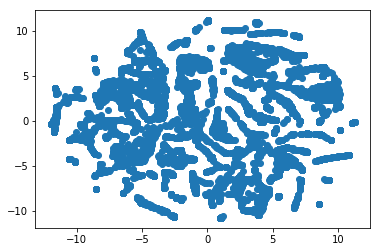

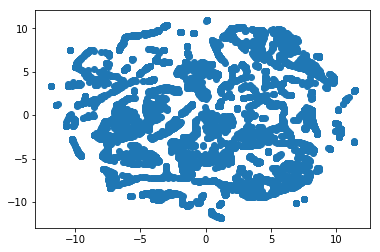

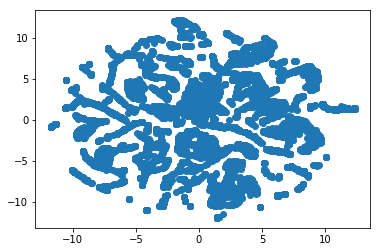

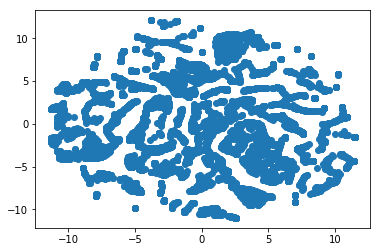

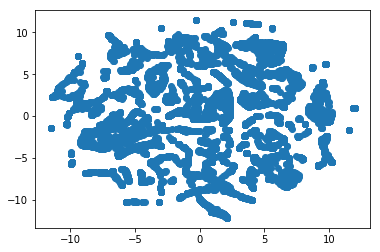

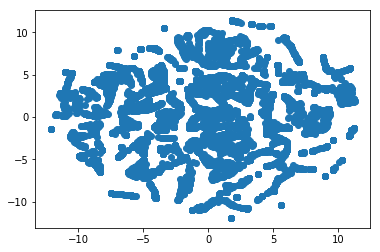

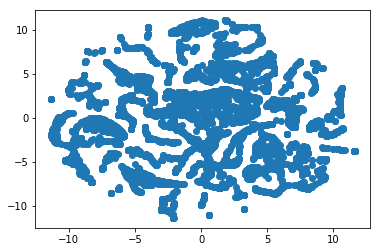

KeyboardInterrupt: 

In [146]:
for i in range(1,32):
    title = "cluster_on_map_day{}.html".format(i)
    m = folium.Map([0, 0], zoom_start=1.5,prefer_canvas=True)
    keep_by_day(i)
    y_kmeans = kmeans_on_pressure_temp()
    plotDot(data,y_kmeans)
    #tsne_algorithm()
    m.save(title)

In [ ]:
#m = folium.Map([0, 0], zoom_start=1.5,prefer_canvas=True)
#keep_by_day(18)
#y_brc = birch_algorithm()
#plotDot(data,y_brc)
#m.save("test.html")